In [1]:
#===========================================================================
# This function defines the RHS vector by evaluate all the source terms
#
#===========================================================================
import time
import sys
import scipy
import pylab
import numpy as np
import matplotlib
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math

import os


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# os.chdir('/content/drive/My Drive/Colab Notebooks/ammonia_cracking')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import Reactor_catalyst_design as reac
import Operational_conditions as oper

from Molecular_weight_i import*
from viscosity_mixture import*
from Cp_mixture import*
from Thermal_conductivity import*
from Pressure_drop import*
from Heat_transfer_coeffs import*
from Kinetic_model import*

Space velocity at working condition: 0.002265884070799893


In [3]:
count =1
P_x = np.ones((reac.Nx))

# plt.rcParams['axes.grid'] = True


#==============================================================
# CONSTRUCT THE 1D PROBLEM WITH CONVECTION-DIFFUSION-REACTION
#==============================================================
def dC_dt(t,Y, reac, oper):

    # print(">> time: ", t)
    #Rearrange the vector Y into the columm matrix [Y1, Y2, ..., YNs, T]
    global count
    global P_x
    #print('gia tri count',count)

    YiT = np.reshape(Y, (reac.Nx, reac.Ns+1), order='F') # each row is molfracs at some position
    Yi_x = YiT[:,:-1] # each column is molefrac of one species
    T_x = YiT[:,-1]
    #---------------------------------------------------------
    #I. Compute the nonlinear source terms of reactions
    #---------------------------------------------------------
    F   = np.zeros(reac.N)

    # Load molecular weights
    Wi = Molecular_weight_i()[:reac.Ns]

    #Set the gas pressure at the inlet
    if(count==1):
        P_x = oper.P0 * np.ones((reac.Nx)) # assume no pressure drop at the first step

    MW_x= Yi_x @ Wi # molecular weight at each x-location
    # print("MW_x: ",MW_x)
    # print("T_x:", T_x)
    rhom_x = P_x / oper.R / T_x # molar density at each location
    rhog_x = MW_x  * rhom_x
    if np.any(rhog_x < 0):
        print("negative rho_g")
    Cpg_x = calc_Cpg_x(Yi_x,T_x)
    if np.any(Cpg_x < 0):
        print("negative Cpg_x")
    mug_x = calc_mug_x(Yi_x,T_x)
    if np.any(mug_x < 0):
        print("negative mug_x")
    #kg_x = calc_kg_x_WA(Yi_x,T_x, mug_x) # weighted average thermal conductivity
    kg_x = calc_kg_x_WA(Yi_x,T_x) # weighted average thermal conductivity
    if np.any(kg_x < 0):
        print("negative kg_x")
        print(YiT[np.where(kg_x < 0)][:])

    #viscosity_i_x = viscosity_i(T_x)
    #print(np.shape(viscosity_i_x))
    #print(viscosity_i_x)

    ug_x = oper.f_t * np.ones(reac.Nx) # need to change if on a mass basis
    #ug_x = 0.1*oper.ug * np.ones(reac.Nx) # need to change if on a mass basis

    #Update the pressure drop
    P_x = oper.P0 * np.ones((reac.Nx)) - pressure_drop_x(rhog_x, mug_x)*reac.xvals

    # print("kg_x: ", kg_x)
    # print("mug_x: ", mug_x)
    # print("rhog_x: ", rhog_x)
    # print("Cpg_x: ", Cpg_x)

    count = count + 1

    UP_x = calc_UP_x(kg_x,mug_x,rhog_x,ug_x,Cpg_x/MW_x)*5.0e6
    Pi_x = Yi_x * np.expand_dims(P_x, axis=-1)
    F = calc_reaction_x(T_x,Pi_x,UP_x,oper.Tf,reac.rho_b,reac.eta)
    F[reac.Ns*reac.Nx:] /= Cpg_x * rhom_x

    #---------------------------------------------------------
    #II. Form the RHS matrix A = convection + diffusion
    #---------------------------------------------------------
    ##########################################################
    # calculate Y_adv and Y_diff componentwise

    Y_diff = np.zeros_like(Y)
    # individual species diffusion
    for spec in range(0,reac.Ns):
        d2Y_i_dx2 = reac.d2_dx2 @ Y[spec*reac.Nx:spec*reac.Nx + reac.Nx]
        Y_diff[spec*reac.Nx:spec*reac.Nx + reac.Nx] = oper.Da * d2Y_i_dx2
        # print(" >>> D_spec >>> ")
        # print(D_spec)
    # temperature diffusion
    # each node has its own Cpg
    d2T_dx2 = reac.d2_dx2 @ Y[reac.Ns*reac.Nx:reac.Ns*reac.Nx + reac.Nx]
    Y_diff[reac.Ns*reac.Nx:reac.Ns*reac.Nx + reac.Nx] = oper.lamdaa * d2T_dx2 / Cpg_x
    # print(" >>> Y_diff >>> ")
    # print(Y_diff)

    Y_adv = np.zeros_like(Y)
    adv_vel = oper.f_t/reac.Ac
    # adv_vel = 0.0
    # individual species advection and temperature
    # all have the same advection term (? to confirm)
    for spec in range(0,reac.Ns+1):
        dY_i_dx = reac.d_dx @ Y[spec*reac.Nx:spec*reac.Nx + reac.Nx]
        Y_adv[spec*reac.Nx:spec*reac.Nx + reac.Nx] = - adv_vel* dY_i_dx


    # Y_BC is needed
    Y_BC = np.zeros_like(Y) # with no further modifications, BCs are fixed at initial value
    for spec in range(0,reac.Ns):
        # C_BC_in = np.zeros((reac.Nx)) # with no further modifications, BCs are Dirichlet and fixed at initial value over time
        # # if inlet has neumann, need to modify the following
        # C_BC[0,0] = -oper.Da*2/reac.dx**2
        # C_BC[0,1] = oper.Da*2/reac.dx**2
        # # if inlet has non-zero neumann, need to modify the following
        # beta_in = 0 # gradient to impose
        # b_in = 2*beta*oper.Da / reac.dx
        # Y_BC[spec*reac.Nx] = np.dot(C_BC_in,Y[spec*reac.Nx:spec*reac.Nx + reac.Nx]) + b_in

        # if outlet has neumann, need to modify the following
        C_BC_out = np.zeros((reac.Nx)) # with no further modifications, BCs are Dirichlet and fixed at initial value over time
        beta_out = 0 # gradient to impose
        b_out = 2*beta_out*oper.Da / reac.dx
        C_BC_out[-1] = -oper.Da*2/reac.dx**2
        C_BC_out[-1] += - adv_vel / reac.dx
        C_BC_out[-2] = oper.Da*2/reac.dx**2
        C_BC_out[-2] += adv_vel / reac.dx
        Y_BC[(spec+1)*reac.Nx - 1] = np.dot(C_BC_out,Y[spec*reac.Nx:spec*reac.Nx + reac.Nx]) + b_out

    ### temperature Neumann
    spec = reac.Ns

    # # if inlet has neumann, need to modify the following
    # C_BC_in = np.zeros((reac.Nx)) # with no further modifications, BCs are Dirichlet and fixed at initial value over time
    # C_BC[0,0] = -oper.Da*2/reac.dx**2 / Cpg[0]
    # C_BC[0,1] = oper.Da*2/reac.dx**2 / Cpg[0]
    # # if inlet has non-zero neumann, need to modify the following
    # beta_in = 0 # gradient to impose
    # b_in = 2*beta_out*oper.lamdaa / reac.dx / Cpg[0]
    # Y_BC[spec*reac.Nx] = np.dot(C_BC_in,Y[spec*reac.Nx:spec*reac.Nx + reac.Nx]) + b_in

    # if outlet has neumann, need to modify the following
    C_BC_out = np.zeros((reac.Nx)) # with no further modifications, BCs are Dirichlet and fixed at initial value over time
    beta_out = 0 # gradient to impose
    dTdt_coeff = rhom_x*Cpg_x
    b_out = 2*beta_out*oper.lamdaa / reac.dx / dTdt_coeff[-1]
    C_BC_out[-1] = -oper.lamdaa*2/reac.dx**2 / dTdt_coeff[-1] # coefficient to boundary node
    C_BC_out[-2] = oper.lamdaa*2/reac.dx**2 / dTdt_coeff[-2] # coefficient to (boundary-1) node
    C_BC_out[-1] += - adv_vel / reac.dx
    C_BC_out[-2] += adv_vel / reac.dx  ## NBS 20240304: check heat capacity in denom.
    Y_BC[(spec+1)*reac.Nx - 1] = np.dot(C_BC_out,Y[spec*reac.Nx:spec*reac.Nx + reac.Nx]) + b_out
    ###

    # print("temp adv: ", Y_adv[-2:])
    # print("temp diff: ", Y_diff[-2:])
    # print("temp BC: ", Y_BC[-2:])

    AY = Y_diff + Y_adv + Y_BC

    #---------------------------------------------------------
    #III. Build the control vector B*u(t)
    #---------------------------------------------------------
    Bu = np.zeros(reac.N)

    # for i in range(0,reac.Ns+1):
    #     # specify input for CO2
    #     if(i==0):
    #         Bu[i*reac.Nx] = (oper.f_CO2/reac.Ac/oper.Da)*reac.dx/((oper.f_t/reac.Ac/oper.Da)*reac.dx + 1.)/oper.dt
    #     # specify input for H2
    #     elif(i==1):
    #         Bu[i*reac.Nx] = (oper.f_H2/reac.Ac/oper.Da)*reac.dx/((oper.f_t/reac.Ac/oper.Da)*reac.dx + 1.)/oper.dt
    #     # specify input for Temperature
    #     elif(i==reac.Ns):
    #         Bu[i*reac.Nx] = oper.T0*(Cpg[1]*oper.f_t/reac.Ac/oper.lamdaa)*reac.dx/((Cpg[1]*oper.f_t/reac.Ac/oper.lamdaa)*reac.dx + 1.)/oper.dt


    # Right hand-sided functions dCi/dt = A*Ci(t) + B*u(t) + F(Ci,t)
    dYdt = AY + Bu + F
    dYdt[::reac.Nx] = 0.0 # at x = 0, dYdt = 0 for fixed-value inlet boundary for all species
    return dYdt



In [4]:

## Initial conditions
# Y0 = np.ones(reac.N)*0.01 # NBS20240222 - shouldnt all other species be zero?
Y0 = np.zeros(reac.N)
for i in range(0,reac.Nx):
    Y0[reac.Ns*reac.Nx + i] = oper.T0

    # initial condition: set in oper
    Y0[i]    = oper.f_NH3/oper.f_t - 0.005
    Y0[reac.Nx+i] = 0.0025
    Y0[2*reac.Nx+i] = 0.0025
    Y0[3*reac.Nx+i] = 0.0#oper.f_AR/oper.f_t - 0.005

t_end = 0.5
NT = 100
tvals = np.linspace(0,t_end,NT+1)
ni_names = "NH3, H2, N2, AR, Temp. (K)"
ni_names = ni_names.split(", ")

gg = dC_dt(0,Y0, reac, oper);

#########################################################
# NBS20240222 solution with solve_ivp from scipy
print("launching solve_ivp...")
tt = time.time()
# solSI = solve_ivp(dC_dt,[0, t_end],Y0,args=(reac, oper), t_eval=tvals, method='Radau')
solSI = solve_ivp(dC_dt,[0, tvals[-1]],Y0,args=(reac, oper), t_eval=tvals, method='LSODA')
elapsed = time.time() - tt
print(' [solve_ivp] The running time is: ',elapsed)

# reshape solutions for visualization
nSteps = len(solSI.t)

specNH3 = np.zeros([nSteps,reac.Nx])
specH2  = np.zeros([nSteps,reac.Nx])
specN2  = np.zeros([nSteps,reac.Nx])
reacT   = np.zeros([nSteps,reac.Nx])

for ti in range(0,nSteps):
    specNH3[ti] = solSI.y.transpose()[ti][0:reac.Nx]
    specH2[ti]  = solSI.y.transpose()[ti][reac.Nx:2*reac.Nx]
    specN2[ti]  = solSI.y.transpose()[ti][2*reac.Nx:3*reac.Nx]
    reacT[ti]   = solSI.y.transpose()[ti][reac.Ns*reac.Nx:(reac.Ns+1)*reac.Nx]



launching solve_ivp...
 [solve_ivp] The running time is:  23.39184832572937


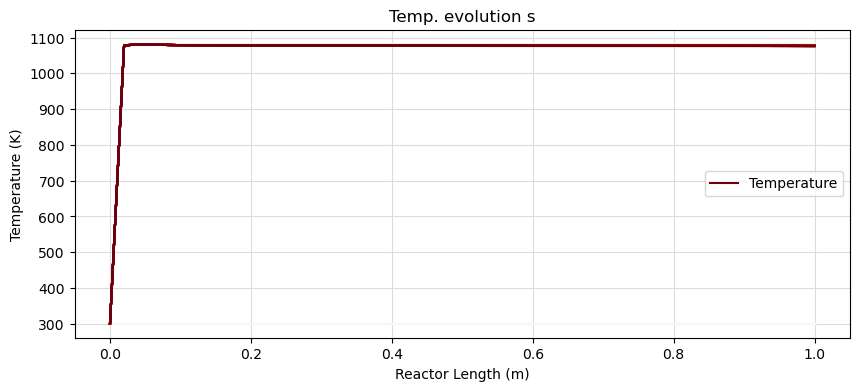

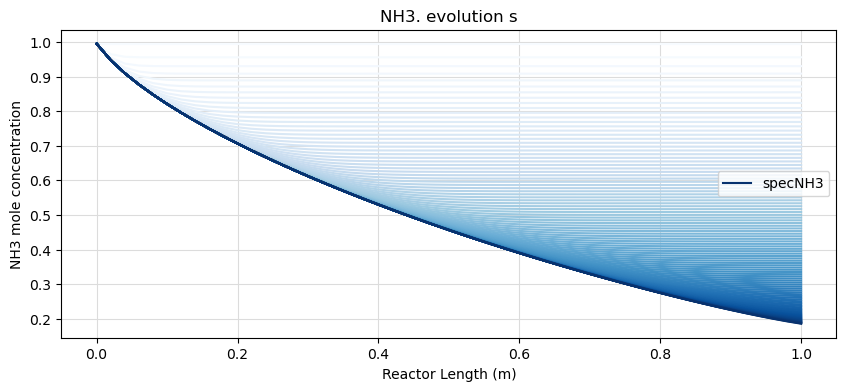

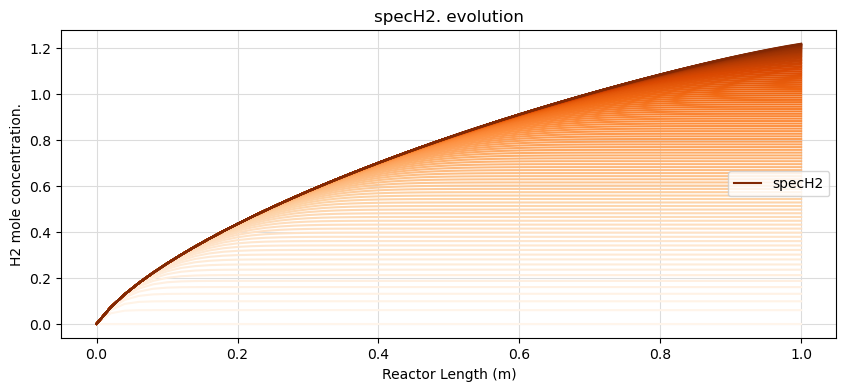

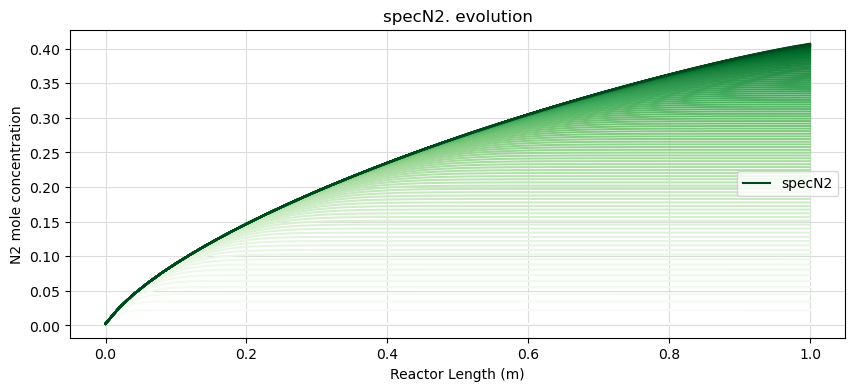

In [5]:
# ####################################

norm = matplotlib.colors.Normalize(vmin=0, vmax=nSteps)
cmap1 = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Blues)
cmap2 = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Oranges)
cmap3 = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Greens)
cmap4 = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmapAll = [cmap1,cmap2,cmap3,cmap4]

figsz = (10,4)

plt.figure(1)
plt.gcf().set_size_inches(figsz)
for ti in range(0,nSteps-1):
    plt.plot(reac.xvals,reacT[ti],color=cmap4.to_rgba(ti))
for ti in range(nSteps-1,nSteps):
    plt.plot(reac.xvals,reacT[ti],color=cmap4.to_rgba(ti),label="Temperature")
ax = plt.gca()
ax.set(xlabel="Reactor Length (m)",ylabel="Temperature (K)",title='Temp. evolution s')
ax.grid(color='gainsboro')
ax.legend(loc='right')

plt.figure(2)
plt.gcf().set_size_inches(figsz)
for ti in range(0,nSteps-1):
    plt.plot(reac.xvals,specNH3[ti],color=cmap1.to_rgba(ti))
for ti in range(nSteps-1,nSteps):
    plt.plot(reac.xvals,specNH3[ti],color=cmap1.to_rgba(ti),label="specNH3")
ax = plt.gca()
ax.set(xlabel="Reactor Length (m)",ylabel="NH3 mole concentration",title='NH3. evolution s')
ax.grid(color='gainsboro')
ax.legend(loc='right')

plt.figure(3)
plt.gcf().set_size_inches(figsz)
for ti in range(0,nSteps-1):
    plt.plot(reac.xvals,specH2[ti],color=cmap2.to_rgba(ti))
for ti in range(nSteps-1,nSteps):
    plt.plot(reac.xvals,specH2[ti],color=cmap2.to_rgba(ti),label="specH2")
ax = plt.gca()
ax.set(xlabel="Reactor Length (m)",ylabel="H2 mole concentration.",title='specH2. evolution')
ax.grid(color='gainsboro')
ax.legend(loc='right')

plt.figure(4)
plt.gcf().set_size_inches(figsz)
for ti in range(0,nSteps-1):
    plt.plot(reac.xvals,specN2[ti],color=cmap3.to_rgba(ti))
for ti in range(nSteps-1,nSteps):
    plt.plot(reac.xvals,specN2[ti],color=cmap3.to_rgba(ti),label="specN2")
ax = plt.gca()
ax.set(xlabel="Reactor Length (m)",ylabel="N2 mole concentration",title='specN2. evolution')
ax.grid(color='gainsboro')
ax.legend(loc='right')

plt.show()
